Intention of this Notebook ist to improve the performance of a "default" CNN network. Hyperparameters will be tested on the second split of a 3 fold inner split (showed the closest to average performance), since variance in performance in splits is relatively low. The goal is to find significant improvements. 

Comparison:
  * Default model average performance: MAE: 6.251872683314947,  RMSE: 8.929572292868341
  * Default model second split of 3 fold inner split performance: MAE: 6.240022255288514, RMSE:  8.938713315589355.
  * Default model 95% confidence interval: MAE: (6.118740486386132, 6.3850055136138675), RMSE: (8.673900578108704, 9.185243421891297). If we see values lower then the lower bounds it may indicate significant improvement and justify further investigation. 

## Set up notebook and environment: 

### Connect to google drive: ###

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras #where?
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.image as mpimg
from keras.utils import plot_model
from sklearn import preprocessing
import gc
from sklearn.model_selection import KFold

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Specify location of all relevant data: (YOU HAVE TO INSERT YOUR FILE LOCATIONS) ###

In [0]:
print("Check correctnes of locations: ")
data_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Data/"
model_saves_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/"
data_filter_location = data_folder_location+"merck_and_co_dup_aa_concat_filter.npy"
X_location = data_folder_location+"X.npy"
y_location = data_folder_location+"y_growth_avg.npy"
print(os.path.isdir(data_folder_location))
print(os.path.isdir(model_saves_folder_location))
print(os.path.isfile(data_filter_location))
print(os.path.isfile(X_location))
print(os.path.isfile(y_location))

Check correctnes of locations: 
True
True
True
True
True


### Function to easily retrieve cleaned data with split either from drive or cache, depending wheter data was already retrieved using this function ###

In [0]:
def retrieve_data(X_loc, y_loc, test_split=0.2, random_state=42):
  if not(os.path.isfile("X_train_H.npy")):
    #Load data from drive
    print("Loading data from drive...")
    X_load = np.load(X_loc)
    y_load = np.load(y_loc)
    filter_load = np.load(data_filter_location)
    
    #Apply pre filter
    X_load = X_load[filter_load]
    y_load = y_load[filter_load]
    gc.collect()
    
    #Remove all entries that have no temperature information #can happen, since for some organism specific temperature information is not available
    temp_label_filter = np.logical_not(np.isnan(y_load))
    X_load = X_load[temp_label_filter]
    y_load = y_load[temp_label_filter]
    gc.collect()
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_load, y_load, test_size=test_split, random_state=random_state) 
    
    #Cache data
    print("Caching data...")
    np.save('X_train_H.npy', X_train)   
    np.save('X_test_H.npy', X_test)   
    np.save('y_train_H.npy', y_train)   
    np.save('y_test_H.npy', y_test) 
    
    return X_train, X_test, y_train, y_test
  else:
    print("Loading data from cache...")
    return np.load('X_train_H.npy'), np.load('X_test_H.npy'), np.load('y_train_H.npy'), np.load('y_test_H.npy') 

In [0]:
X_train, X_test, y_train, y_test = retrieve_data(X_location,y_location)
gc.collect()

Loading data from drive...
Caching data...


0

### Create inner split filters

In [0]:
kf = KFold(n_splits=3, random_state=42375, shuffle=True)

In [0]:
k_splits = []
for train_index, test_index in kf.split(X_train):
  k_splits.append((train_index, test_index))

In [0]:
train_index_01, test_index_01 = k_splits[0]
train_index_02, test_index_02 = k_splits[1] #showed average performance
train_index_03, test_index_03 = k_splits[2]

In [0]:
train_index_01[:10] #just rough check that its the same data

array([ 0,  1,  2,  4,  5,  6,  9, 10, 11, 13])

### Create appropriate subset of data (filter, and scale)

Performance tests will only happen on the second split of the 3-fold split, due to low variance and resouce intensivenes of task. Tus data can be pre calculated for all data.

In [0]:
gc.collect()

120

In [0]:
X_train_inner, X_test_inner = X_train[train_index_02], X_train[test_index_02]
y_train_inner, y_test_inner = y_train[train_index_02], y_train[test_index_02]

In [0]:
standard_scaler_inner = preprocessing.StandardScaler()
y_train_scaled_inner = standard_scaler_inner.fit_transform(y_train_inner.reshape(-1, 1)).reshape((len(y_train_inner))) #only fit on y_train to prevent information leakage

#actually nonsensical, but in this case not a big problem, since its the tune set
standard_scaler_test_inner = preprocessing.StandardScaler()
y_test_scaled_inner = standard_scaler_test_inner.fit_transform(y_test_inner.reshape(-1, 1)).reshape((len(y_test_inner))) #scale y_test seperately

In [0]:
print(X_train_inner.shape)
print(y_train_scaled_inner.shape)
print(X_test_inner.shape)
print(y_test_scaled_inner.shape)

(4099573, 650)
(4099573,)
(2049786, 650)
(2049786,)


In [0]:
y_offset = len(y_test_inner)%8 #needed because of 8 tpu cores, only for validation?
print(y_offset)

2


In [0]:
del X_train
del X_test
del y_train
del y_test
gc.collect()

0

## Supplementary functions

In [0]:
def train_on_TPU_regression(model,model_save_loc, X_train, y_train, X_test, y_test, batch_size=1024, epochs=25, save_best_only=True, period=1, train_patience=3, mse=True, weight_loc=None):
  print("Batch size: {} (this corresponds to {} on GPUs)".format(batch_size,batch_size//8))
  print("Optimization criterion MSE: ", str(mse))
  print("Epochs: ", epochs)
  print("Patience: ", train_patience)
  print("Period: ", period)
  print("Save best only: ",save_best_only)
  print("Model save location: ",model_save_loc)
  print("\n")
  
  #Identify TPU worker
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  
  #Useful to avoid clutter from old models / layers.
  tf.keras.backend.clear_session()

  #Convert model to TPU model
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  print("\n")

  #Compile the model
  if mse:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss=tf.keras.losses.mean_squared_error,
      metrics=['mse']
    )
  else:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), 
      loss=tf.keras.losses.mean_absolute_error,
      metrics=['mae']
    )
    
  if not(weight_loc is None):
    tpu_model.load_weights(weight_loc)
  
  #Configure how to save model and early stopping
  callbacks_list = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath=model_save_loc,
          save_weights_only=True,
          monitor='val_loss', 
          save_best_only=save_best_only,
          mode='auto',
          period=period),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                       patience=train_patience, #more than 3 doesnt help (except when using generator), since the TPU runs out ouf memory for some reason???
                                       mode='auto')
  ]
  
  history = tpu_model.fit(X_train,
                          y_train,
                          validation_data=(X_test,y_test),
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=callbacks_list,
                          verbose=1)

  return tpu_model, history

In [0]:
def calc_reg_pred(model, weight_loc, X_test, y_test, batch_size=1024, mse=True, scaler=None):
  print("TPU worker setup:")
  #Identify TPU worker
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  
  #Useful to avoid clutter from old models / layers.
  tf.keras.backend.clear_session()
  
  #Convert model to TPU model
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  print("\n")
  
  #Compile the model #doesnt really matter which loss function here
  if mse:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), 
      loss=tf.keras.losses.mean_squared_error,
      metrics=['mse']
    )
  else:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss=tf.keras.losses.mean_absolute_error,
      metrics=['mae']
    )
  
  tpu_model.load_weights(weight_loc)
  
  print("Calculating predictions:")
  y_pred = tpu_model.predict(X_test, batch_size=1024, verbose=1)

  if not(scaler is None):
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
  rmse_err = np.sqrt(mean_squared_error(y_test, y_pred)) 
  mae_err = mean_absolute_error(y_test, y_pred)
  
  return y_pred, rmse_err, mae_err

In [0]:
def plt_model(model,figure_size=(25,25)):
  plt.figure(figsize=figure_size)
  plot_model(model, to_file='model.png')
  plt.imshow(mpimg.imread('model.png'))
  plt.show()

## Define, Train and Test Models 


In [0]:
SEQUENCE_LEN = 650
CLASSES = 21 #now that sequences with non cannonical AAs removed there are 20 left and "0" encoding "None"

**Whatever comes after the "vs" is what is being tested right there.**

### i.	Label scaled (z-score) vs non scaled //MAE: 6.076013762760478, RMSE:  8.832355718806802 //Potentially better


In [0]:
#model name:
model_name = "i"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 669,993
Trainable params: 667,177
Non-trainable params: 2,816
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_inner, X_test_inner[:-y_offset], y_test_inner[:-y_offset])



```


Batch size: 1024 (this corresponds to 128 on GPUs)
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_i.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.87.136.226:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14494559449515522937)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5408749852827329809)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17179559125252396921)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 11481602454649730107)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 17952735922369356685)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 17218427111281345181)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 13542157448048899917)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 16095172053989350244)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 2570331009396860795)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 7154639345391623066)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 16332187648928266026)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.390700817108154 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 135.7572 - mean_squared_error: 135.7573INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.381511926651001 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 135.7504 - mean_squared_error: 135.7505INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.840724945068359 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.994586706161499 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 447s 109us/sample - loss: 135.7447 - mean_squared_error: 135.7449 - val_loss: 133.2139 - val_mean_squared_error: 133.2139
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 92.8044 - mean_squared_error: 92.8045INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 401s 98us/sample - loss: 92.8034 - mean_squared_error: 92.8035 - val_loss: 98.2103 - val_mean_squared_error: 98.2103
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 87.3732 - mean_squared_error: 87.3732INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 398s 97us/sample - loss: 87.3729 - mean_squared_error: 87.3729 - val_loss: 93.9865 - val_mean_squared_error: 93.9864
Epoch 4/25
4099573/4099573 [==============================] - 395s 96us/sample - loss: 83.3630 - mean_squared_error: 83.3630 - val_loss: 96.3473 - val_mean_squared_error: 96.3473
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 80.1954 - mean_squared_error: 80.1953INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 402s 98us/sample - loss: 80.1943 - mean_squared_error: 80.1942 - val_loss: 89.2933 - val_mean_squared_error: 89.2933
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 77.5296 - mean_squared_error: 77.5298INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 399s 97us/sample - loss: 77.5289 - mean_squared_error: 77.5291 - val_loss: 83.9869 - val_mean_squared_error: 83.9869
Epoch 7/25
4099573/4099573 [==============================] - 398s 97us/sample - loss: 75.1702 - mean_squared_error: 75.1703 - val_loss: 85.9922 - val_mean_squared_error: 85.9923
Epoch 8/25
4099573/4099573 [==============================] - 393s 96us/sample - loss: 73.0261 - mean_squared_error: 73.0260 - val_loss: 87.2320 - val_mean_squared_error: 87.2321
Epoch 9/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 71.0405 - mean_squared_error: 71.0404INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 392s 96us/sample - loss: 71.0414 - mean_squared_error: 71.0414 - val_loss: 82.8710 - val_mean_squared_error: 82.8709
Epoch 10/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 69.2945 - mean_squared_error: 69.2946INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 404s 98us/sample - loss: 69.2948 - mean_squared_error: 69.2949 - val_loss: 78.0132 - val_mean_squared_error: 78.0132
Epoch 11/25
4099573/4099573 [==============================] - 401s 98us/sample - loss: 67.6734 - mean_squared_error: 67.6733 - val_loss: 79.8993 - val_mean_squared_error: 79.8994
Epoch 12/25
4099573/4099573 [==============================] - 405s 99us/sample - loss: 66.1423 - mean_squared_error: 66.1424 - val_loss: 84.5431 - val_mean_squared_error: 84.5432
Epoch 13/25
4099573/4099573 [==============================] - 407s 99us/sample - loss: 64.7180 - mean_squared_error: 64.7180 - val_loss: 97.2042 - val_mean_squared_error: 97.2042


```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset])

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.076013762760478
Root mean squared error:  8.832355718806802
```



### ii.	Optimize MSE vs MAE //MAE: 5.851835552985131, RMSE: 9.20268968367297 


In [0]:
#model name:
model_name = "ii"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 669,993
Trainable params: 667,177
Non-trainable params: 2,816
_________________________________________________________________


```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], mse=False)



```


Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  False
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_ii.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.87.136.226:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14494559449515522937)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5408749852827329809)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17179559125252396921)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 11481602454649730107)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 17952735922369356685)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 17218427111281345181)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 13542157448048899917)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 16095172053989350244)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 2570331009396860795)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 7154639345391623066)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 16332187648928266026)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.689203500747681 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.5507 - mean_absolute_error: 0.5507INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.425231695175171 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5507 - mean_absolute_error: 0.5507INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.501775741577148 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.140720367431641 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 450s 110us/sample - loss: 0.5507 - mean_absolute_error: 0.5507 - val_loss: 0.5517 - val_mean_absolute_error: 0.5517
Epoch 2/25
4099573/4099573 [==============================] - 402s 98us/sample - loss: 0.5170 - mean_absolute_error: 0.5170 - val_loss: 0.5834 - val_mean_absolute_error: 0.5834
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5004 - mean_absolute_error: 0.5004INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 402s 98us/sample - loss: 0.5004 - mean_absolute_error: 0.5004 - val_loss: 0.5206 - val_mean_absolute_error: 0.5206
Epoch 4/25
4099573/4099573 [==============================] - 398s 97us/sample - loss: 0.4886 - mean_absolute_error: 0.4886 - val_loss: 0.5319 - val_mean_absolute_error: 0.5319
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4797 - mean_absolute_error: 0.4797INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 403s 98us/sample - loss: 0.4797 - mean_absolute_error: 0.4797 - val_loss: 0.5022 - val_mean_absolute_error: 0.5022
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4719 - mean_absolute_error: 0.4719INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 406s 99us/sample - loss: 0.4719 - mean_absolute_error: 0.4719 - val_loss: 0.4906 - val_mean_absolute_error: 0.4906
Epoch 7/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4655 - mean_absolute_error: 0.4655INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 403s 98us/sample - loss: 0.4655 - mean_absolute_error: 0.4655 - val_loss: 0.4876 - val_mean_absolute_error: 0.4876
Epoch 8/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4596 - mean_absolute_error: 0.4596INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 399s 97us/sample - loss: 0.4596 - mean_absolute_error: 0.4596 - val_loss: 0.4812 - val_mean_absolute_error: 0.4812
Epoch 9/25
4099573/4099573 [==============================] - 395s 96us/sample - loss: 0.4543 - mean_absolute_error: 0.4543 - val_loss: 0.4819 - val_mean_absolute_error: 0.4819
Epoch 10/25
4099573/4099573 [==============================] - 397s 97us/sample - loss: 0.4497 - mean_absolute_error: 0.4497 - val_loss: 0.4814 - val_mean_absolute_error: 0.4814
Epoch 11/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4451 - mean_absolute_error: 0.4451INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 396s 97us/sample - loss: 0.4451 - mean_absolute_error: 0.4451 - val_loss: 0.4755 - val_mean_absolute_error: 0.4755
Epoch 12/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4412 - mean_absolute_error: 0.4412INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 395s 96us/sample - loss: 0.4412 - mean_absolute_error: 0.4412 - val_loss: 0.4668 - val_mean_absolute_error: 0.4668
Epoch 13/25
4099573/4099573 [==============================] - 393s 96us/sample - loss: 0.4372 - mean_absolute_error: 0.4372 - val_loss: 0.4671 - val_mean_absolute_error: 0.4671
Epoch 14/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4338 - mean_absolute_error: 0.4338INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 401s 98us/sample - loss: 0.4338 - mean_absolute_error: 0.4338 - val_loss: 0.4608 - val_mean_absolute_error: 0.4608
Epoch 15/25
4099573/4099573 [==============================] - 398s 97us/sample - loss: 0.4304 - mean_absolute_error: 0.4304 - val_loss: 0.4616 - val_mean_absolute_error: 0.4616
Epoch 16/25
4099573/4099573 [==============================] - 398s 97us/sample - loss: 0.4271 - mean_absolute_error: 0.4271 - val_loss: 0.4673 - val_mean_absolute_error: 0.4673
Epoch 17/25
4099573/4099573 [==============================] - 398s 97us/sample - loss: 0.4245 - mean_absolute_error: 0.4245 - val_loss: 0.4781 - val_mean_absolute_error: 0.4781


```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner, mse=False)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.851835552985131
Root mean squared error:  9.20268968367297
```



### iii.	Batch size 1024 vs 512 //MAE:  6.122175053509608, RMSE: 8.76508756699281 //Promising



In [0]:
#model name:
model_name = "iii"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 669,993
Trainable params: 667,177
Non-trainable params: 2,816
_________________________________________________________________


```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=512)



```


Batch size: 512 (this corresponds to 64 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_iii.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.19.153.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11349385430994905532)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14080209582092061163)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16773418793868829421)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1429072472759349194)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12439308416214226226)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3383239542517471313)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17236616273159268388)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5980440432826758332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 4510099459945211541)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 12286061235165313398)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 17846541302065893886)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.811039209365845 secs
INFO:tensorflow:Setting weights on TPU model.
4098560/4099573 [============================>.] - ETA: 0s - loss: 0.6536 - mean_squared_error: 0.6536INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.209686756134033 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6535 - mean_squared_error: 0.6535INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(64, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.647715091705322 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.017207860946655 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 670s 163us/sample - loss: 0.6535 - mean_squared_error: 0.6535 - val_loss: 0.8837 - val_mean_squared_error: 0.8837
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5757 - mean_squared_error: 0.5757INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 627s 153us/sample - loss: 0.5757 - mean_squared_error: 0.5757 - val_loss: 0.5666 - val_mean_squared_error: 0.5666
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5381 - mean_squared_error: 0.5381INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 630s 154us/sample - loss: 0.5381 - mean_squared_error: 0.5381 - val_loss: 0.5342 - val_mean_squared_error: 0.5342
Epoch 4/25
4099573/4099573 [==============================] - 629s 153us/sample - loss: 0.5132 - mean_squared_error: 0.5132 - val_loss: 0.5824 - val_mean_squared_error: 0.5824
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4924 - mean_squared_error: 0.4924INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 633s 154us/sample - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.5067 - val_mean_squared_error: 0.5067
Epoch 6/25
4099573/4099573 [==============================] - 631s 154us/sample - loss: 0.4753 - mean_squared_error: 0.4753 - val_loss: 0.5743 - val_mean_squared_error: 0.5743
Epoch 7/25
3232768/4099573 [======================>.......] - ETA: 2:02 - loss: 0.4600 - mean_squared_error: 0.4600Buffered data was truncated after reaching the output size limit.


```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.122175053509608
Root mean squared error:  8.76508756699281
```



### iv.	Embeddding 8 vs 4 //MAE: 6.326742977577777, RMSE:  9.049283928819388 //Worse


In [0]:
#model name:
model_name = "iv"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 4, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 4)            84        
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          3712      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
__________

In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])

```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_iv.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.19.153.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11349385430994905532)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14080209582092061163)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16773418793868829421)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1429072472759349194)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12439308416214226226)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3383239542517471313)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17236616273159268388)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5980440432826758332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 4510099459945211541)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 12286061235165313398)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 17846541302065893886)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.590111970901489 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6771 - mean_squared_error: 0.6771INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.37800669670105 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6771 - mean_squared_error: 0.6771INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.460169315338135 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.083421230316162 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 448s 109us/sample - loss: 0.6771 - mean_squared_error: 0.6771 - val_loss: 0.6918 - val_mean_squared_error: 0.6918
Epoch 2/25
4099573/4099573 [==============================] - 393s 96us/sample - loss: 0.5990 - mean_squared_error: 0.5990 - val_loss: 0.7554 - val_mean_squared_error: 0.7554
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5615 - mean_squared_error: 0.5615INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 395s 96us/sample - loss: 0.5615 - mean_squared_error: 0.5615 - val_loss: 0.6761 - val_mean_squared_error: 0.6761
Epoch 4/25
4099573/4099573 [==============================] - 390s 95us/sample - loss: 0.5332 - mean_squared_error: 0.5332 - val_loss: 0.9175 - val_mean_squared_error: 0.9175
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5112 - mean_squared_error: 0.5112INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 395s 96us/sample - loss: 0.5112 - mean_squared_error: 0.5112 - val_loss: 0.6464 - val_mean_squared_error: 0.6464
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4919 - mean_squared_error: 0.4919INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 394s 96us/sample - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.5255 - val_mean_squared_error: 0.5255
Epoch 7/25
4099573/4099573 [==============================] - 392s 96us/sample - loss: 0.4756 - mean_squared_error: 0.4756 - val_loss: 0.5448 - val_mean_squared_error: 0.5448
Epoch 8/25
4099573/4099573 [==============================] - 397s 97us/sample - loss: 0.4608 - mean_squared_error: 0.4608 - val_loss: 0.6785 - val_mean_squared_error: 0.6785
Epoch 9/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4477 - mean_squared_error: 0.4477INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 397s 97us/sample - loss: 0.4477 - mean_squared_error: 0.4477 - val_loss: 0.5072 - val_mean_squared_error: 0.5072
Epoch 10/25
4099573/4099573 [==============================] - 392s 96us/sample - loss: 0.4357 - mean_squared_error: 0.4357 - val_loss: 0.5558 - val_mean_squared_error: 0.5558
Epoch 11/25
4099573/4099573 [==============================] - 393s 96us/sample - loss: 0.4249 - mean_squared_error: 0.4249 - val_loss: 0.5097 - val_mean_squared_error: 0.5097
Epoch 12/25
4099573/4099573 [==============================] - 392s 96us/sample - loss: 0.4148 - mean_squared_error: 0.4148 - val_loss: 0.5123 - val_mean_squared_error: 0.5123
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)

```
Mean absolute error:  6.326742977577777
Root mean squared error:  9.049283928819388
```

### v.	First layer kernel 7 stride 2 vs kernel 3 //MAE:  6.823990339799243, RMSE:  9.382415083272855 //Significantly worse


In [0]:
#model name:
model_name = "v"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 648, 128)          3200      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 648, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 648, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 646, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 646, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 646, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 644, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 644, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 644, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 214, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 212, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 212, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 212, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 210, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 210, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 210, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 208, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 208, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 208, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 665,897
Trainable params: 663,081
Non-trainable params: 2,816
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])

```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_v.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.19.153.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11349385430994905532)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14080209582092061163)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16773418793868829421)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1429072472759349194)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12439308416214226226)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3383239542517471313)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17236616273159268388)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5980440432826758332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 4510099459945211541)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 12286061235165313398)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 17846541302065893886)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.939005374908447 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6440 - mean_squared_error: 0.6440INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.873688697814941 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6440 - mean_squared_error: 0.6440INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.463123798370361 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.232492923736572 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 465s 113us/sample - loss: 0.6440 - mean_squared_error: 0.6440 - val_loss: 0.7799 - val_mean_squared_error: 0.7799
Epoch 2/25
4099573/4099573 [==============================] - 415s 101us/sample - loss: 0.5645 - mean_squared_error: 0.5645 - val_loss: 0.7826 - val_mean_squared_error: 0.7826
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5272 - mean_squared_error: 0.5272INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 419s 102us/sample - loss: 0.5272 - mean_squared_error: 0.5272 - val_loss: 0.5997 - val_mean_squared_error: 0.5997
Epoch 4/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4990 - mean_squared_error: 0.4990INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 417s 102us/sample - loss: 0.4990 - mean_squared_error: 0.4990 - val_loss: 0.5457 - val_mean_squared_error: 0.5457
Epoch 5/25
4099573/4099573 [==============================] - 418s 102us/sample - loss: 0.4766 - mean_squared_error: 0.4766 - val_loss: 0.5830 - val_mean_squared_error: 0.5830
Epoch 6/25
4099573/4099573 [==============================] - 418s 102us/sample - loss: 0.4580 - mean_squared_error: 0.4580 - val_loss: 0.6292 - val_mean_squared_error: 0.6292
Epoch 7/25
4099573/4099573 [==============================] - 421s 103us/sample - loss: 0.4415 - mean_squared_error: 0.4415 - val_loss: 0.6438 - val_mean_squared_error: 0.6438
```

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.823990339799243
Root mean squared error:  9.382415083272855
```



###vi.	Max pool vs average pool //MAE:  6.219364989423227, RMSE:  8.939939969103646 //No difference

In [0]:
#model name:
model_name = "vi"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.AveragePooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 106, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 669,993
Trainable params: 667,177
Non-trainable params: 2,816
_________________________________________________________________
```

In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])

```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_vi.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.19.153.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11349385430994905532)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14080209582092061163)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16773418793868829421)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1429072472759349194)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12439308416214226226)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3383239542517471313)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17236616273159268388)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5980440432826758332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 4510099459945211541)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 12286061235165313398)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 17846541302065893886)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.940715551376343 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6545 - mean_squared_error: 0.6545INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.52178168296814 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6544 - mean_squared_error: 0.6544INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.4917426109313965 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.39042067527771 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 445s 109us/sample - loss: 0.6544 - mean_squared_error: 0.6544 - val_loss: 2.1339 - val_mean_squared_error: 2.1339
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5768 - mean_squared_error: 0.5768INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 400s 97us/sample - loss: 0.5768 - mean_squared_error: 0.5768 - val_loss: 1.2703 - val_mean_squared_error: 1.2703
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5423 - mean_squared_error: 0.5423INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 399s 97us/sample - loss: 0.5423 - mean_squared_error: 0.5423 - val_loss: 0.5804 - val_mean_squared_error: 0.5804
Epoch 4/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5142 - mean_squared_error: 0.5142INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 398s 97us/sample - loss: 0.5142 - mean_squared_error: 0.5142 - val_loss: 0.5516 - val_mean_squared_error: 0.5516
Epoch 5/25
4099573/4099573 [==============================] - 398s 97us/sample - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.5711 - val_mean_squared_error: 0.5711
Epoch 6/25
4099573/4099573 [==============================] - 406s 99us/sample - loss: 0.4737 - mean_squared_error: 0.4737 - val_loss: 0.5864 - val_mean_squared_error: 0.5864
Epoch 7/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4578 - mean_squared_error: 0.4578INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 407s 99us/sample - loss: 0.4578 - mean_squared_error: 0.4578 - val_loss: 0.5023 - val_mean_squared_error: 0.5023
Epoch 8/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4438 - mean_squared_error: 0.4438INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 408s 100us/sample - loss: 0.4438 - mean_squared_error: 0.4438 - val_loss: 0.4947 - val_mean_squared_error: 0.4947
Epoch 9/25
4099573/4099573 [==============================] - 403s 98us/sample - loss: 0.4309 - mean_squared_error: 0.4309 - val_loss: 0.5310 - val_mean_squared_error: 0.5310
Epoch 10/25
4099573/4099573 [==============================] - 407s 99us/sample - loss: 0.4192 - mean_squared_error: 0.4192 - val_loss: 0.5536 - val_mean_squared_error: 0.5536
Epoch 11/25
4099573/4099573 [==============================] - 404s 98us/sample - loss: 0.4086 - mean_squared_error: 0.4086 - val_loss: 0.5180 - val_mean_squared_error: 0.5180
```

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.219364989423227
Root mean squared error:  8.939939969103646
```



###vii.	Global average vs global max pool //MAE: 6.198519998379552, RMSE:  8.874210860066288 //Potentially better


In [0]:
#model name:
model_name = "vii"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

```
_______________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 256)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 669,993
Trainable params: 667,177
Non-trainable params: 2,816
_________________________________________________________________
```

In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])



```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_vii.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.19.153.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11349385430994905532)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14080209582092061163)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16773418793868829421)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1429072472759349194)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12439308416214226226)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3383239542517471313)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17236616273159268388)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5980440432826758332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 4510099459945211541)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 12286061235165313398)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 17846541302065893886)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.988607883453369 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6700 - mean_squared_error: 0.6700INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.583921909332275 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6700 - mean_squared_error: 0.6700INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.488574266433716 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.128533601760864 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 447s 109us/sample - loss: 0.6700 - mean_squared_error: 0.6700 - val_loss: 1.3489 - val_mean_squared_error: 1.3489
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5821 - mean_squared_error: 0.5821INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 401s 98us/sample - loss: 0.5821 - mean_squared_error: 0.5821 - val_loss: 0.5739 - val_mean_squared_error: 0.5739
Epoch 3/25
4099573/4099573 [==============================] - 401s 98us/sample - loss: 0.5417 - mean_squared_error: 0.5417 - val_loss: 0.7973 - val_mean_squared_error: 0.7973
Epoch 4/25
4099573/4099573 [==============================] - 401s 98us/sample - loss: 0.5113 - mean_squared_error: 0.5113 - val_loss: 0.5794 - val_mean_squared_error: 0.5794
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4873 - mean_squared_error: 0.4873INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 402s 98us/sample - loss: 0.4873 - mean_squared_error: 0.4873 - val_loss: 0.5172 - val_mean_squared_error: 0.5172
Epoch 6/25
4099573/4099573 [==============================] - 398s 97us/sample - loss: 0.4672 - mean_squared_error: 0.4672 - val_loss: 0.6206 - val_mean_squared_error: 0.6206
Epoch 7/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4497 - mean_squared_error: 0.4497INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 404s 99us/sample - loss: 0.4496 - mean_squared_error: 0.4496 - val_loss: 0.5089 - val_mean_squared_error: 0.5089
Epoch 8/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4340 - mean_squared_error: 0.4340INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 406s 99us/sample - loss: 0.4340 - mean_squared_error: 0.4340 - val_loss: 0.4934 - val_mean_squared_error: 0.4934
Epoch 9/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4198 - mean_squared_error: 0.4198INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 406s 99us/sample - loss: 0.4198 - mean_squared_error: 0.4198 - val_loss: 0.4880 - val_mean_squared_error: 0.4880
Epoch 10/25
4099573/4099573 [==============================] - 403s 98us/sample - loss: 0.4080 - mean_squared_error: 0.4080 - val_loss: 0.5032 - val_mean_squared_error: 0.5032
Epoch 11/25
4099573/4099573 [==============================] - 398s 97us/sample - loss: 0.3968 - mean_squared_error: 0.3968 - val_loss: 0.5881 - val_mean_squared_error: 0.5881
Epoch 12/25
4099573/4099573 [==============================] - 402s 98us/sample - loss: 0.3866 - mean_squared_error: 0.3866 - val_loss: 0.4917 - val_mean_squared_error: 0.4917
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.198519998379552
Root mean squared error:  8.874210860066288
```



###viii.	2 vs 3 stages (stages divided by max pool) //MAE: 6.053134201998302, RMSE:  8.837730955639133  //Potentially better

In [0]:
#model name:
model_name = "viii"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 33, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 31, 512)           393728    
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 31, 512)           2048      
_________________________________________________________________
activation_6 (Activation)    (None, 31, 512)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 29, 512)           786944    
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 29, 512)           2048      
_________________________________________________________________
activation_7 (Activation)    (None, 29, 512)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 27, 512)           786944    
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 27, 512)           2048      
_________________________________________________________________
activation_8 (Activation)    (None, 27, 512)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 512)               2048      
_________________________________________________________________
activation_9 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
=================================================================
Total params: 2,841,897
Trainable params: 2,835,497
Non-trainable params: 6,400
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])



```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_viii.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.19.153.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11349385430994905532)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14080209582092061163)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16773418793868829421)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1429072472759349194)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12439308416214226226)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3383239542517471313)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17236616273159268388)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5980440432826758332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 4510099459945211541)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 12286061235165313398)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 17846541302065893886)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 9.425430536270142 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6640 - mean_squared_error: 0.6640INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.56057333946228 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6640 - mean_squared_error: 0.6640INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.052857875823975 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.962599039077759 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 555s 135us/sample - loss: 0.6640 - mean_squared_error: 0.6640 - val_loss: 0.9519 - val_mean_squared_error: 0.9519
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5789 - mean_squared_error: 0.5789INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 481s 117us/sample - loss: 0.5789 - mean_squared_error: 0.5789 - val_loss: 0.7622 - val_mean_squared_error: 0.7622
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5408 - mean_squared_error: 0.5408INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 484s 118us/sample - loss: 0.5408 - mean_squared_error: 0.5408 - val_loss: 0.5694 - val_mean_squared_error: 0.5694
Epoch 4/25
4099573/4099573 [==============================] - 482s 118us/sample - loss: 0.5092 - mean_squared_error: 0.5092 - val_loss: 0.6351 - val_mean_squared_error: 0.6351
Epoch 5/25
4099573/4099573 [==============================] - 481s 117us/sample - loss: 0.4813 - mean_squared_error: 0.4813 - val_loss: 0.6314 - val_mean_squared_error: 0.6314
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4577 - mean_squared_error: 0.4577INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 486s 119us/sample - loss: 0.4578 - mean_squared_error: 0.4578 - val_loss: 0.5327 - val_mean_squared_error: 0.5327
Epoch 7/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4354 - mean_squared_error: 0.4354INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 484s 118us/sample - loss: 0.4354 - mean_squared_error: 0.4354 - val_loss: 0.4841 - val_mean_squared_error: 0.4841
Epoch 8/25
4099573/4099573 [==============================] - 482s 118us/sample - loss: 0.4158 - mean_squared_error: 0.4158 - val_loss: 0.6549 - val_mean_squared_error: 0.6549
Epoch 9/25
4099573/4099573 [==============================] - 482s 118us/sample - loss: 0.3975 - mean_squared_error: 0.3975 - val_loss: 0.5828 - val_mean_squared_error: 0.5828
Epoch 10/25
4099573/4099573 [==============================] - 483s 118us/sample - loss: 0.3812 - mean_squared_error: 0.3812 - val_loss: 0.4991 - val_mean_squared_error: 0.4991
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.053134201998302
Root mean squared error:  8.837730955639133
```



###ix.	3 vs 4 CNN layers per stage //MAE: 6.658984722654489, RMSE:  9.379709500880276 //Significantly worse


In [0]:
#model name:
model_name = "ix"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 316, 128)          49280     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 316, 128)          512       
_________________________________________________________________
activation_3 (Activation)    (None, 316, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 105, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 103, 256)          98560     
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 103, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 103, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 101, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 101, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 101, 256)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 99, 256)           196864    
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 99, 256)           1024      
_________________________________________________________________
activation_6 (Activation)    (None, 99, 256)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 97, 256)           196864    
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 97, 256)           1024      
_________________________________________________________________
activation_7 (Activation)    (None, 97, 256)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 256)               1024      
_________________________________________________________________
activation_8 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 917,673
Trainable params: 914,089
Non-trainable params: 3,584
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])



```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_ix.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.19.153.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11349385430994905532)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14080209582092061163)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16773418793868829421)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1429072472759349194)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12439308416214226226)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3383239542517471313)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17236616273159268388)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5980440432826758332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 4510099459945211541)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 12286061235165313398)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 17846541302065893886)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.154675722122192 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6532 - mean_squared_error: 0.6532INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.771426677703857 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6532 - mean_squared_error: 0.6532INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.041480779647827 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.217130661010742 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 523s 127us/sample - loss: 0.6532 - mean_squared_error: 0.6532 - val_loss: 0.8757 - val_mean_squared_error: 0.8757
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5759 - mean_squared_error: 0.5759INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 464s 113us/sample - loss: 0.5759 - mean_squared_error: 0.5759 - val_loss: 0.6130 - val_mean_squared_error: 0.6130
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5404 - mean_squared_error: 0.5404INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 461s 113us/sample - loss: 0.5404 - mean_squared_error: 0.5404 - val_loss: 0.5452 - val_mean_squared_error: 0.5452
Epoch 4/25
4099573/4099573 [==============================] - 456s 111us/sample - loss: 0.5146 - mean_squared_error: 0.5146 - val_loss: 0.6134 - val_mean_squared_error: 0.6134
Epoch 5/25
4099573/4099573 [==============================] - 459s 112us/sample - loss: 0.4931 - mean_squared_error: 0.4931 - val_loss: 0.5707 - val_mean_squared_error: 0.5707
Epoch 6/25
4099573/4099573 [==============================] - 460s 112us/sample - loss: 0.4760 - mean_squared_error: 0.4760 - val_loss: 0.5725 - val_mean_squared_error: 0.5725
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.658984722654489
Root mean squared error:  9.379709500880276
```



###x.	128, 256 vs 256,512 filter counts per CNN stage //MAE: 5.825502006710439, RMSE:  8.554933590354343 //Significantly better


In [0]:
#model name:
model_name = "x"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(256, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 256)          14592     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 256)          1024      
_________________________________________________________________
activation (Activation)      (None, 322, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 256)          196864    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 320, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 256)          196864    
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 318, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 256)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 512)          393728    
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 512)          2048      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 512)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 512)          786944    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 512)          2048      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 512)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 512)          786944    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 512)          2048      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 512)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 512)               2048      
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
=================================================================
Total params: 2,650,537
Trainable params: 2,644,905
Non-trainable params: 5,632
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])



```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_x.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.19.153.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11349385430994905532)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14080209582092061163)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16773418793868829421)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1429072472759349194)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12439308416214226226)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3383239542517471313)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17236616273159268388)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5980440432826758332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 4510099459945211541)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 12286061235165313398)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 17846541302065893886)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.936978578567505 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6535 - mean_squared_error: 0.6535INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.871067762374878 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6535 - mean_squared_error: 0.6535INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.61654257774353 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.144700050354004 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 502s 122us/sample - loss: 0.6535 - mean_squared_error: 0.6535 - val_loss: 2.7610 - val_mean_squared_error: 2.7610
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5650 - mean_squared_error: 0.5650INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 453s 110us/sample - loss: 0.5650 - mean_squared_error: 0.5650 - val_loss: 0.6590 - val_mean_squared_error: 0.6590
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5184 - mean_squared_error: 0.5184INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 453s 111us/sample - loss: 0.5184 - mean_squared_error: 0.5184 - val_loss: 0.5511 - val_mean_squared_error: 0.5511
Epoch 4/25
4099573/4099573 [==============================] - 448s 109us/sample - loss: 0.4809 - mean_squared_error: 0.4809 - val_loss: 0.8152 - val_mean_squared_error: 0.8152
Epoch 5/25
4099573/4099573 [==============================] - 447s 109us/sample - loss: 0.4498 - mean_squared_error: 0.4498 - val_loss: 0.6814 - val_mean_squared_error: 0.6814
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4243 - mean_squared_error: 0.4243INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 448s 109us/sample - loss: 0.4243 - mean_squared_error: 0.4243 - val_loss: 0.5249 - val_mean_squared_error: 0.5249
Epoch 7/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4008 - mean_squared_error: 0.4008INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 450s 110us/sample - loss: 0.4008 - mean_squared_error: 0.4008 - val_loss: 0.5116 - val_mean_squared_error: 0.5116
Epoch 8/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.3803 - mean_squared_error: 0.3803INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 448s 109us/sample - loss: 0.3803 - mean_squared_error: 0.3803 - val_loss: 0.4718 - val_mean_squared_error: 0.4718
Epoch 9/25
4099573/4099573 [==============================] - 443s 108us/sample - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.5986 - val_mean_squared_error: 0.5986
Epoch 10/25
4099573/4099573 [==============================] - 447s 109us/sample - loss: 0.3442 - mean_squared_error: 0.3442 - val_loss: 0.5197 - val_mean_squared_error: 0.5197
Epoch 11/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.3282 - mean_squared_error: 0.3282INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 447s 109us/sample - loss: 0.3283 - mean_squared_error: 0.3283 - val_loss: 0.4535 - val_mean_squared_error: 0.4535
Epoch 12/25
4099573/4099573 [==============================] - 444s 108us/sample - loss: 0.3138 - mean_squared_error: 0.3138 - val_loss: 0.4608 - val_mean_squared_error: 0.4608
Epoch 13/25
4099573/4099573 [==============================] - 445s 109us/sample - loss: 0.3001 - mean_squared_error: 0.3001 - val_loss: 0.4651 - val_mean_squared_error: 0.4651
Epoch 14/25
1612800/4099573 [==========>...................] - ETA: 3:57 - loss: 0.2797 - mean_squared_error: 0.2797Buffered data was truncated after reaching the output size limit.
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  5.825502006710439
Root mean squared error:  8.554933590354343
```



### xi.	2 vs 3 fully connected layers //MAE:  6.17672777898976, RMSE:  8.883239127232303 //Potentially better


In [0]:
#model name:
model_name = "xi"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 256)               1024      
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
=================================================================
Total params: 736,809
Trainable params: 733,481
Non-trainable params: 3,328
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])



```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_xi.hdf5



WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.26.161.138:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 12673986033914401704)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10837600860812545469)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12556111887363146574)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16084886084741707268)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5727114590196635521)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 7414803096489331867)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 16709423536985471471)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 7127978111857528780)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 5418126534446515389)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 18346722837910492534)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 9738865372057196313)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_20'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_4_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.238240957260132 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6436 - mean_squared_error: 0.6436INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_20'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_4_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.86644721031189 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6435 - mean_squared_error: 0.6435INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_20'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_4_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.853506326675415 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_20'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_4_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.583862066268921 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 871s 213us/sample - loss: 0.6435 - mean_squared_error: 0.6435 - val_loss: 4.5471 - val_mean_squared_error: 4.5471
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5659 - mean_squared_error: 0.5659INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 423s 103us/sample - loss: 0.5659 - mean_squared_error: 0.5659 - val_loss: 0.8832 - val_mean_squared_error: 0.8832
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5308 - mean_squared_error: 0.5308INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 420s 103us/sample - loss: 0.5308 - mean_squared_error: 0.5308 - val_loss: 0.5640 - val_mean_squared_error: 0.5640
Epoch 4/25
4099573/4099573 [==============================] - 418s 102us/sample - loss: 0.5053 - mean_squared_error: 0.5053 - val_loss: 0.5809 - val_mean_squared_error: 0.5809
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4850 - mean_squared_error: 0.4850INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 420s 102us/sample - loss: 0.4850 - mean_squared_error: 0.4850 - val_loss: 0.5579 - val_mean_squared_error: 0.5579
Epoch 6/25
4099573/4099573 [==============================] - 425s 104us/sample - loss: 0.4679 - mean_squared_error: 0.4679 - val_loss: 0.5613 - val_mean_squared_error: 0.5613
Epoch 7/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4523 - mean_squared_error: 0.4523
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.17672777898976
Root mean squared error:  8.883239127232303
```



### xii.	ResNet type feed forward concatenation //MAE: 6.035696263031642, RMSE:  8.796745531785053 //Promising

In [0]:
#model name:
model_name = "xii"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x_mid)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x_mid = tf.keras.layers.GlobalAveragePooling1D()(x_mid)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

x = tf.keras.layers.concatenate([x_mid, x], axis=-1)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 8)       168         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 322, 128)     7296        embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 322, 128)     512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 322, 128)     0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 320, 128)     49280       activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 320, 128)     512         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 128)     0           batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 318, 128)     49280       activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_2 (Batch (None, 318, 128)     512         conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 318, 128)     0           batch_normalization_v1_2[0][0]   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 106, 128)     0           activation_2[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 104, 256)     98560       max_pooling1d[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_3 (Batch (None, 104, 256)     1024        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 104, 256)     0           batch_normalization_v1_3[0][0]   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 102, 256)     196864      activation_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 102, 256)     1024        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 102, 256)     0           batch_normalization_v1_4[0][0]   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 256)     196864      activation_4[0][0]               
__________________________________________________________________________________________________
batch_normalization_v1_5 (Batch (None, 100, 256)     1024        conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 256)     0           batch_normalization_v1_5[0][0]   
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 128)          0           activation_2[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 256)          0           activation_5[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 384)          0           global_average_pooling1d[0][0]   
                                                                 global_average_pooling1d_1[0][0] 
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          98560       concatenate[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1_6 (Batch (None, 256)          1024        dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 256)          0           batch_normalization_v1_6[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            257         activation_6[0][0]               
==================================================================================================
Total params: 702,761
Trainable params: 699,945
Non-trainable params: 2,816
__________________________________________________________________________________________________
```



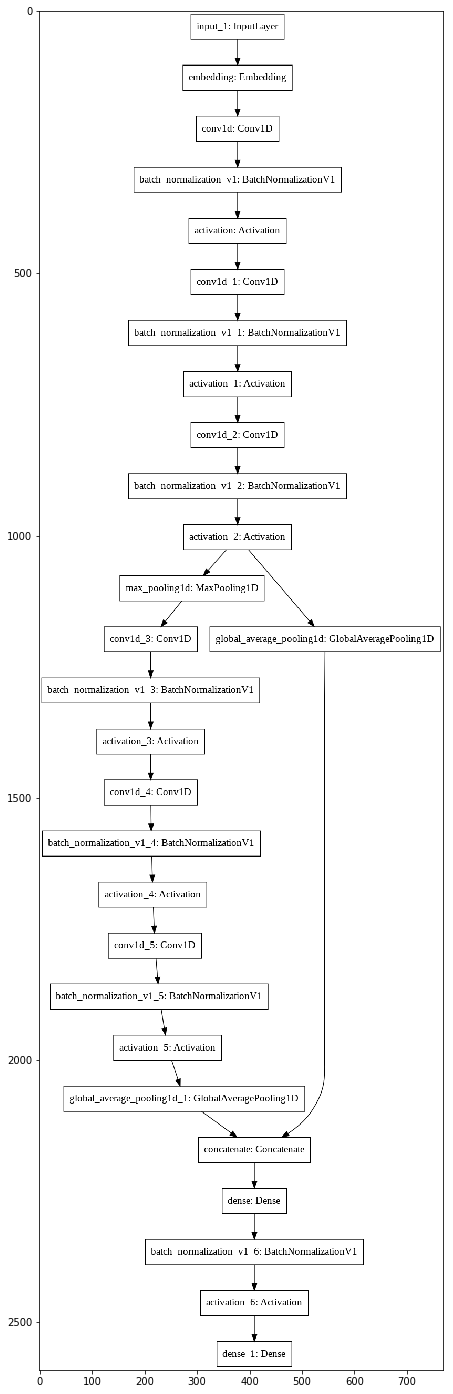

In [0]:
#plot model
plt_model(model)

In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])



```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_xii.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.113.32.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2085274587762135440)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14132380918734491335)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1400207629764384067)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2610160740570331609)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12601441904887026250)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12245044461565163595)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 937115320268804004)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 15628920438446328280)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 11321445158460057905)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 338995971991697862)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 3708225360176882797)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/tpu/python/tpu/keras_support.py:302: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.5843284130096436 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6540 - mean_squared_error: 0.6540INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.491815805435181 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6540 - mean_squared_error: 0.6540INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.773053407669067 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.110403060913086 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 450s 110us/sample - loss: 0.6540 - mean_squared_error: 0.6540 - val_loss: 1.1117 - val_mean_squared_error: 1.1117
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5791 - mean_squared_error: 0.5791INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 396s 97us/sample - loss: 0.5791 - mean_squared_error: 0.5791 - val_loss: 0.8998 - val_mean_squared_error: 0.8998
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5431 - mean_squared_error: 0.5431INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 395s 96us/sample - loss: 0.5431 - mean_squared_error: 0.5431 - val_loss: 0.6123 - val_mean_squared_error: 0.6123
Epoch 4/25
4099573/4099573 [==============================] - 391s 95us/sample - loss: 0.5163 - mean_squared_error: 0.5163 - val_loss: 0.6637 - val_mean_squared_error: 0.6637
Epoch 5/25
4099573/4099573 [==============================] - 393s 96us/sample - loss: 0.4957 - mean_squared_error: 0.4957 - val_loss: 0.6308 - val_mean_squared_error: 0.6308
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4776 - mean_squared_error: 0.4776INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 395s 96us/sample - loss: 0.4776 - mean_squared_error: 0.4776 - val_loss: 0.5490 - val_mean_squared_error: 0.5490
Epoch 7/25
4099573/4099573 [==============================] - 395s 96us/sample - loss: 0.4627 - mean_squared_error: 0.4627 - val_loss: 0.5509 - val_mean_squared_error: 0.5509
Epoch 8/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4485 - mean_squared_error: 0.4485INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 395s 96us/sample - loss: 0.4485 - mean_squared_error: 0.4485 - val_loss: 0.5290 - val_mean_squared_error: 0.5290
Epoch 9/25
4099573/4099573 [==============================] - 389s 95us/sample - loss: 0.4360 - mean_squared_error: 0.4360 - val_loss: 0.5685 - val_mean_squared_error: 0.5685
Epoch 10/25
4099573/4099573 [==============================] - 391s 95us/sample - loss: 0.4249 - mean_squared_error: 0.4249 - val_loss: 0.5291 - val_mean_squared_error: 0.5291
Epoch 11/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4144 - mean_squared_error: 0.4144INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 395s 96us/sample - loss: 0.4144 - mean_squared_error: 0.4144 - val_loss: 0.5115 - val_mean_squared_error: 0.5115
Epoch 12/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4045 - mean_squared_error: 0.4045INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 394s 96us/sample - loss: 0.4045 - mean_squared_error: 0.4045 - val_loss: 0.5019 - val_mean_squared_error: 0.5019
Epoch 13/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.3959 - mean_squared_error: 0.3959INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 399s 97us/sample - loss: 0.3959 - mean_squared_error: 0.3959 - val_loss: 0.4911 - val_mean_squared_error: 0.4911
Epoch 14/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.3877 - mean_squared_error: 0.3877INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 395s 96us/sample - loss: 0.3877 - mean_squared_error: 0.3877 - val_loss: 0.4801 - val_mean_squared_error: 0.4801
Epoch 15/25
4099573/4099573 [==============================] - 390s 95us/sample - loss: 0.3806 - mean_squared_error: 0.3806 - val_loss: 0.5384 - val_mean_squared_error: 0.5384
Epoch 16/25
4099573/4099573 [==============================] - 392s 96us/sample - loss: 0.3736 - mean_squared_error: 0.3736 - val_loss: 0.4817 - val_mean_squared_error: 0.4817
Epoch 17/25
4099573/4099573 [==============================] - 392s 96us/sample - loss: 0.3662 - mean_squared_error: 0.3662 - val_loss: 0.4928 - val_mean_squared_error: 0.4928
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.035696263031642
Root mean squared error:  8.796745531785053
```



### inv-i.	First layer kernel 7 stride 2 vs kernel 7 //MAE:  6.692297803694302, RMSE:  9.24391573579766 //Significantly worse


In [0]:
#model name:
model_name = "inv-i"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 644, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 644, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 644, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 642, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 642, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 642, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 640, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 640, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 640, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 213, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 211, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 211, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 211, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 209, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 209, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 209, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 207, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 207, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 207, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 669,993
Trainable params: 667,177
Non-trainable params: 2,816
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])

```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_inv-i.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.113.32.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2085274587762135440)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14132380918734491335)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1400207629764384067)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2610160740570331609)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12601441904887026250)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12245044461565163595)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 937115320268804004)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 15628920438446328280)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 11321445158460057905)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 338995971991697862)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 3708225360176882797)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.1813483238220215 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6396 - mean_squared_error: 0.6396INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.029156923294067 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6395 - mean_squared_error: 0.6395INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.623291015625 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.187852144241333 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 471s 115us/sample - loss: 0.6395 - mean_squared_error: 0.6395 - val_loss: 0.7551 - val_mean_squared_error: 0.7551
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5623 - mean_squared_error: 0.5623INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 419s 102us/sample - loss: 0.5623 - mean_squared_error: 0.5623 - val_loss: 0.7036 - val_mean_squared_error: 0.7036
Epoch 3/25
4099573/4099573 [==============================] - 419s 102us/sample - loss: 0.5272 - mean_squared_error: 0.5272 - val_loss: 0.7221 - val_mean_squared_error: 0.7221
Epoch 4/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4994 - mean_squared_error: 0.4994INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 416s 102us/sample - loss: 0.4994 - mean_squared_error: 0.4994 - val_loss: 0.5294 - val_mean_squared_error: 0.5294
Epoch 5/25
4099573/4099573 [==============================] - 417s 102us/sample - loss: 0.4791 - mean_squared_error: 0.4791 - val_loss: 0.6611 - val_mean_squared_error: 0.6611
Epoch 6/25
4099573/4099573 [==============================] - 418s 102us/sample - loss: 0.4616 - mean_squared_error: 0.4616 - val_loss: 0.5382 - val_mean_squared_error: 0.5382
Epoch 7/25
4099573/4099573 [==============================] - 420s 103us/sample - loss: 0.4468 - mean_squared_error: 0.4468 - val_loss: 0.6619 - val_mean_squared_error: 0.6619
```

In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)

```
Mean absolute error:  6.692297803694302
Root mean squared error:  9.24391573579766
```

### inv-ii.	3 vs 2 CNN layers per stage //MAE: 6.609578921730352, RMSE:  9.288911375170162 //Significantly worse


In [0]:
#model name:
model_name = "inv-ii"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 256)               1024      
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 422,313
Trainable params: 420,265
Non-trainable params: 2,048
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])



```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_inv-ii.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.113.32.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2085274587762135440)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14132380918734491335)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1400207629764384067)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2610160740570331609)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12601441904887026250)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12245044461565163595)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 937115320268804004)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 15628920438446328280)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 11321445158460057905)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 338995971991697862)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 3708225360176882797)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.577225923538208 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6578 - mean_squared_error: 0.6578INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.30019736289978 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6578 - mean_squared_error: 0.6578INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.581422328948975 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.575764894485474 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 385s 94us/sample - loss: 0.6578 - mean_squared_error: 0.6578 - val_loss: 0.7939 - val_mean_squared_error: 0.7939
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5835 - mean_squared_error: 0.5835INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 344s 84us/sample - loss: 0.5835 - mean_squared_error: 0.5835 - val_loss: 0.7813 - val_mean_squared_error: 0.7813
Epoch 3/25
4099573/4099573 [==============================] - 350s 85us/sample - loss: 0.5507 - mean_squared_error: 0.5507 - val_loss: 0.8408 - val_mean_squared_error: 0.8408
Epoch 4/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5251 - mean_squared_error: 0.5251INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 347s 85us/sample - loss: 0.5251 - mean_squared_error: 0.5251 - val_loss: 0.6350 - val_mean_squared_error: 0.6350
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5040 - mean_squared_error: 0.5040INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 348s 85us/sample - loss: 0.5040 - mean_squared_error: 0.5040 - val_loss: 0.5812 - val_mean_squared_error: 0.5812
Epoch 6/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4872 - mean_squared_error: 0.4872INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 347s 85us/sample - loss: 0.4872 - mean_squared_error: 0.4872 - val_loss: 0.5341 - val_mean_squared_error: 0.5341
Epoch 7/25
4099573/4099573 [==============================] - 345s 84us/sample - loss: 0.4726 - mean_squared_error: 0.4726 - val_loss: 0.5493 - val_mean_squared_error: 0.5493
Epoch 8/25
4099573/4099573 [==============================] - 346s 84us/sample - loss: 0.4603 - mean_squared_error: 0.4603 - val_loss: 0.5921 - val_mean_squared_error: 0.5921
Epoch 9/25
4099573/4099573 [==============================] - 349s 85us/sample - loss: 0.4487 - mean_squared_error: 0.4487 - val_loss: 0.6943 - val_mean_squared_error: 0.6943
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)

```
Mean absolute error:  6.609578921730352
Root mean squared error:  9.288911375170162
```

### inv-iii.	Activation ReLu vs ELU //MAE:  6.714949259570356, RMSE:  9.1910315778379 //Significantly worse


In [0]:
#model name:
model_name = "inv-iii"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("elu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("elu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("elu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("elu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("elu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 669,993
Trainable params: 667,177
Non-trainable params: 2,816
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset])



```
Batch size: 1024 (this corresponds to 128 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_inv-iii.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.113.32.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2085274587762135440)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14132380918734491335)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1400207629764384067)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2610160740570331609)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12601441904887026250)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12245044461565163595)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 937115320268804004)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 15628920438446328280)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 11321445158460057905)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 338995971991697862)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 3708225360176882797)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.655500173568726 secs
INFO:tensorflow:Setting weights on TPU model.
4098048/4099573 [============================>.] - ETA: 0s - loss: 0.6899 - mean_squared_error: 0.6899INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(62,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(62, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(62, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.830300807952881 secs
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6899 - mean_squared_error: 0.6899INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.619662046432495 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(95,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(95, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(95, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.118403196334839 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 456s 111us/sample - loss: 0.6899 - mean_squared_error: 0.6899 - val_loss: 1.7562 - val_mean_squared_error: 1.7562
Epoch 2/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6127 - mean_squared_error: 0.6127INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 404s 99us/sample - loss: 0.6127 - mean_squared_error: 0.6127 - val_loss: 0.8009 - val_mean_squared_error: 0.8009
Epoch 3/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5778 - mean_squared_error: 0.5778INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 403s 98us/sample - loss: 0.5778 - mean_squared_error: 0.5778 - val_loss: 0.6449 - val_mean_squared_error: 0.6449
Epoch 4/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5503 - mean_squared_error: 0.5503INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 403s 98us/sample - loss: 0.5503 - mean_squared_error: 0.5503 - val_loss: 0.5642 - val_mean_squared_error: 0.5642
Epoch 5/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.5284 - mean_squared_error: 0.5284INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 403s 98us/sample - loss: 0.5284 - mean_squared_error: 0.5284 - val_loss: 0.5494 - val_mean_squared_error: 0.5494
Epoch 6/25
4099573/4099573 [==============================] - 402s 98us/sample - loss: 0.5090 - mean_squared_error: 0.5090 - val_loss: 0.5835 - val_mean_squared_error: 0.5835
Epoch 7/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4926 - mean_squared_error: 0.4926INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 404s 99us/sample - loss: 0.4926 - mean_squared_error: 0.4926 - val_loss: 0.5332 - val_mean_squared_error: 0.5332
Epoch 8/25
4099573/4099573 [==============================] - 402s 98us/sample - loss: 0.4777 - mean_squared_error: 0.4777 - val_loss: 0.8167 - val_mean_squared_error: 0.8167
Epoch 9/25
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.4641 - mean_squared_error: 0.4641INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 405s 99us/sample - loss: 0.4641 - mean_squared_error: 0.4641 - val_loss: 0.5219 - val_mean_squared_error: 0.5219
Epoch 10/25
4099573/4099573 [==============================] - 401s 98us/sample - loss: 0.4515 - mean_squared_error: 0.4515 - val_loss: 0.9100 - val_mean_squared_error: 0.9100
Epoch 11/25
4099573/4099573 [==============================] - 400s 97us/sample - loss: 0.4401 - mean_squared_error: 0.4401 - val_loss: 0.5603 - val_mean_squared_error: 0.5603
Epoch 12/25
4099573/4099573 [==============================] - 402s 98us/sample - loss: 0.4294 - mean_squared_error: 0.4294 - val_loss: 0.6081 - val_mean_squared_error: 0.6081
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.714949259570356
Root mean squared error:  9.1910315778379
```



### inv-iv.	Batch size 1024 vs 256 //MAE:  6.397378103003846, RMSE:  8.994399006614517 //Somewhat worse



In [0]:
#model name:
model_name = "inv-iv"
model_save_loc = model_saves_folder_location+"model_hypertuning_"+model_name+".hdf5"

In [0]:
#define model:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()



```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 669,993
Trainable params: 667,177
Non-trainable params: 2,816
_________________________________________________________________
```



In [0]:
#train model
tpu_model, history = train_on_TPU_regression(model, model_save_loc, X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], batch_size=256)



```
Batch size: 256 (this corresponds to 32 on GPUs)
Optimization criterion MSE:  True
Epochs:  25
Patience:  3
Period:  1
Save best only:  True
Model save location:  gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Hypertuning/model_hypertuning_inv-iv.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.113.32.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2085274587762135440)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14132380918734491335)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1400207629764384067)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2610160740570331609)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12601441904887026250)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12245044461565163595)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 937115320268804004)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 15628920438446328280)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 11321445158460057905)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 338995971991697862)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 17179869184, 3708225360176882797)
WARNING:tensorflow:tpu_model (from tensorflow.contrib.tpu.python.tpu.keras_support) is experimental and may change or be removed at any time, and without warning.


Train on 4099573 samples, validate on 2049784 samples
Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(32,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(32, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(32, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.206702470779419 secs
INFO:tensorflow:Setting weights on TPU model.
4099072/4099573 [============================>.] - ETA: 0s - loss: 0.6672 - mean_squared_error: 0.6672INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(30,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(30, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(30, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.619325399398804 secs
4099328/4099573 [============================>.] - ETA: 0s - loss: 0.6672 - mean_squared_error: 0.6672INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(32,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(32, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(32, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.297632694244385 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(31,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(31, 650), dtype=tf.float32, name='input_10'), TensorSpec(shape=(31, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.401971340179443 secs
INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 1177s 287us/sample - loss: 0.6672 - mean_squared_error: 0.6672 - val_loss: 0.6244 - val_mean_squared_error: 0.6244
Epoch 2/25
4099573/4099573 [==============================] - 1141s 278us/sample - loss: 0.5840 - mean_squared_error: 0.5840 - val_loss: 0.7324 - val_mean_squared_error: 0.7324
Epoch 3/25
4099328/4099573 [============================>.] - ETA: 0s - loss: 0.5468 - mean_squared_error: 0.5468INFO:tensorflow:Copying TPU weights to the CPU
4099573/4099573 [==============================] - 1143s 279us/sample - loss: 0.5468 - mean_squared_error: 0.5468 - val_loss: 0.5743 - val_mean_squared_error: 0.5743
Epoch 4/25
1368064/4099573 [=========>....................] - ETA: 11:37 - loss: 0.5238 - mean_squared_error: 0.5238Buffered data was truncated after reaching the output size limit.
```



In [0]:
#validate model
y_preds, rmse_err, mae_err = calc_reg_pred(model, model_save_loc, X_test_inner[:-y_offset], y_test_inner[:-y_offset], scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)

```
Mean absolute error:  6.397378103003846
Root mean squared error:  8.994399006614517
```

## Results

*  See comments after each model performance above
*  The decrease in performance when replacing a filter kernel size 7 stride 2  with kernel size 7 is the reduced receptive field